---

# Preprocessing: Regridding of the global unstructured data to a structured grid. 

## Imports

In [44]:
import numpy as np 
from pathlib import Path 
import xarray as xr 
import xesmf as xe 
print('xesmf version:', xe.__version__)

# suppress warnings (for clarity)
import warnings
warnings.filterwarnings('ignore')

xesmf version: 0.8.7


## Read in unstructured global data on MPAS grid

In [45]:
mpas_path = Path('/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_save/')

# see how many timesteps you would like to read in at the same time
# we take only one day here to keep the example easy) 
file_names = list(mpas_path.glob('diag.3.75km.2020-07-01*00.nc'))
file_names.sort()
len(file_names)

48

### Which variable to track on? 

Here we choose the **total ice water path** since the vertically integrated amount of frozen hydrometeors is an indicator for deep convection, since updrafts in deep convective clouds transport moist air high into the troposphere. 

This can be replaced with any other proxy for deep convection or variable of interest. 

We also add **liquid water path** and **surface precipitation**, to compute some storm statistics based on these fields later on. The extra fields could also be practical if you want to apply additional criteria to your storms (e.g. filter out only those that produce heavy rainfall over a certain threshold). 

In [46]:
# Read in global data for the following variables 
variables = ['ice_water_path', 'liquid_water_path', 'rainnc'] 
# Store datasets in dictionary 
datasets = dict()

for fname in file_names: 
    for var in variables: 
        ds = xr.open_dataset(fname)[var].compute()
        if fname == file_names[0]:
            datasets[var] = ds
        else:
            datasets[var] = xr.concat([datasets[var], ds], dim = 'Time')
        ds.close()

# merge all variables to one xarray.Dataset
ds = xr.Dataset(datasets)

In [47]:
ds

<xarray.Dataset> Size: 24GB
Dimensions:            (Time: 48, nCells: 41943042)
Dimensions without coordinates: Time, nCells
Data variables:
    ice_water_path     (Time, nCells) float32 8GB 22.14 16.39 16.04 ... 0.0 0.0
    liquid_water_path  (Time, nCells) float32 8GB 0.0 0.0 ... 0.0001689 1.473
    rainnc             (Time, nCells) float32 8GB 93.77 94.13 ... 43.92 12.8

## Regridding with **esmpy**

#### Source grid information

To define the source grid, we need information on the lat/lon values for each grid cell on the unstructured grid. 

In this case, we have a global grid with 41943042 grid cells. 

In [58]:
# Read in grid information for our MPAS simulation 
static_file_path = Path('/glade/campaign/mmm/wmr/skamaroc/NSC_2023')
grid = xr.open_dataset(static_file_path / 'x1.41943042.static.nc')

# Get lat/lon values from MPAS grid file 
lat_cell = grid['latCell'].values * 180 / np.pi  # radians to degrees
lon_cell = grid['lonCell'].values * 180 / np.pi

# Assign these coordinates to data 
ds.coords['lat'] = (('nCells',), lat_cell)
ds.coords['lon'] = (('nCells',), lon_cell)

# Source dataset: 1d array with attached lat/lon values 
source_ds = xr.Dataset({
    'lat': (['points'], lat_cell),
    'lon': (['points'], lon_cell),
    'ice_water_path': (['points'], ds['ice_water_path'].isel(Time=0).values)
})

#### Target grid information 

(0.1 deg- spaced regular grid with 1800 latitudes and 3600 longitudes - a total of 6480000 grid cells) 

In [57]:
# Define the latitude and longitude ranges with 0.1-degree spacing
latitudes = np.arange(-90, 90, 0.1) 
longitudes = np.arange(-180, 180, 0.1)  
lat, lon = np.meshgrid(latitudes, longitudes)

# Create an xarray Dataset for the target lat-lon grid 
target_grid = xr.Dataset({'lat': (['lat'], latitudes),'lon': (['lon'], longitudes)}) 

#### Regridder class 

This step only needs to be done once, since the class contains information about the grid structure that stays the same for each time step and variable. 

Note that the creation of the regridder can take a little time, but the following regridding steps per timesteps should be fast. 

In [59]:
regridder = xe.Regridder(
    source_ds,  # just one timestep
    target_grid,
    method='nearest_s2d',
    locstream_in=True,
    reuse_weights=False)

### Loop through the time steps (and variables if you want to regrid more than one) 

In [60]:
# Dictionary to hold lists of regridded DataArrays per variable
regridded_vars = {var: [] for var in variables}

# Loop over time steps
for t in range(len(ds.Time)):
    for var in variables:
        print(f"Regridding timestep {t} for variable {ds[var].name}: {ds[var].attrs.get('long_name', '')}")
        data_timestep = ds[var].isel(Time=t)

        # Regrid and add time dimension back
        regridded_t = regridder(data_timestep)
        regridded_t = regridded_t.expand_dims(time=[ds.Time.values[t]])

        # Save to variable's list
        regridded_vars[var].append(regridded_t)

# Concatenate regridded time slices per variable
regridded_vars_concat = {var: xr.concat(regridded_list, dim='time') 
                         for var, regridded_list in regridded_vars.items()}

# Combine into one dataset
regridded_dataset = xr.Dataset(regridded_vars_concat)

Regridding timestep 0 for variable ice_water_path: vertical integral of rho (qi+qs+qg)
Regridding timestep 0 for variable liquid_water_path: vertical integral of rho (qc+qr)
Regridding timestep 0 for variable rainnc: accumulated total grid-scale precipitation
Regridding timestep 1 for variable ice_water_path: vertical integral of rho (qi+qs+qg)
Regridding timestep 1 for variable liquid_water_path: vertical integral of rho (qc+qr)
Regridding timestep 1 for variable rainnc: accumulated total grid-scale precipitation
Regridding timestep 2 for variable ice_water_path: vertical integral of rho (qi+qs+qg)
Regridding timestep 2 for variable liquid_water_path: vertical integral of rho (qc+qr)
Regridding timestep 2 for variable rainnc: accumulated total grid-scale precipitation
Regridding timestep 3 for variable ice_water_path: vertical integral of rho (qi+qs+qg)
Regridding timestep 3 for variable liquid_water_path: vertical integral of rho (qc+qr)
Regridding timestep 3 for variable rainnc: acc

### Visualize output 

In [28]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

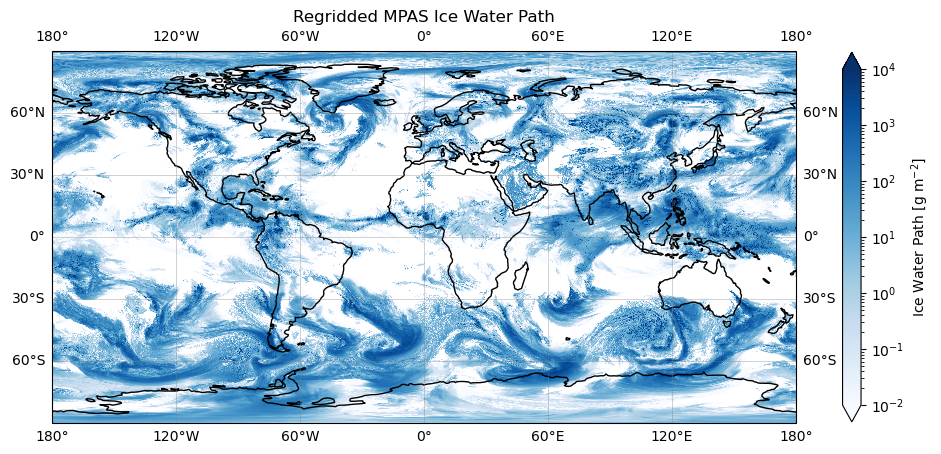

In [29]:
# plot first timestep of ice water path
regridded = regridded_dataset['ice_water_path'].isel(time=0)

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # PlateCarree expects lat/lon coords

# Plot the DataArray using xarray's plot function, but give it the axis
regridded.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  
    cmap='Blues',
    norm=LogNorm(vmin=1e-2, vmax=1e4),
    cbar_kwargs={'label': 'Ice Water Path [g m$^{-2}$]', 'shrink': 0.8}
)

# Add coastlines
ax.coastlines(resolution='110m', linewidth=1)

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

plt.title('Regridded MPAS Ice Water Path')
plt.show()

### Save regridded data (optional, but practical in most cases)

In [62]:
# Add meta data 

# Times 
start = np.datetime64('2020-07-01T00:00:00')
end = np.datetime64('2020-07-01T23:30:00')
times = np.arange(start, end + np.timedelta64(1, 's'), np.timedelta64(30, 'm'))
regridded_dataset = regridded_dataset.assign_coords(time=times)

for var in variables:

    # Rename the variable
    regridded_dataset[var].name = "ice_water_path"
    
    # Assign attributes
    regridded_dataset[var].attrs.update({
        'units': ds[var].units, 
        'long_name': ds[var].long_name,
        'regrid_method': 'nearest_s2d',
        'source': 'MPAS-A DYAMOND 3',
        'comment': 'Regridded from MPAS unstructured mesh to 0.1° lat-lon grid'})

In [63]:
#save to netCDF file 
outname = 'MPAS_regridded_2020_07_01.nc'
regridded_dataset.to_netcdf(outname)

---

## Resources and references

- The full documentation of **xESMF** on **[Readthedocs](https://xesmf.readthedocs.io/en/stable/)**
- Alternative regridding methods (not covered in this cookbook):
  * [ESMF](https://earthsystemmodeling.org/docs/release/latest/ESMF_refdoc/) - Fortran, not the Python interface
  * [TempestRemap](https://github.com/ClimateGlobalChange/tempestremap)
  * [CDO](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html)
